# Model of alcohol consumption in high school students

This section of the analysis will attempt to construct a model to predict:

* Walc - level of workday alcohol consumption
* Dalc - level of weekend alcohol consumption
* binge_drinker - a high level (4-5) of weekend alcohol consumption accompanied by a low level (1-2) of weekday alcohol consumption.
* heavy_drinker - a higher level (4-5) of weekend alcohol consumption accompanied by a high level (4-5) of weekday alcohol consumption.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
%matplotlib inline 
#to allow plots to render in the notebook

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({'font.size': 18})

# Reading in file and checking columns

In [30]:
data = pd.read_csv('../input/student_math_por_formatted.csv')
print(data.shape)
print(data.columns)

(1044, 51)
Index(['Unnamed: 0', 'school', 'sex', 'age', 'address', 'famsize', 'Pstatus',
       'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'schoolsup',
       'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet',
       'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health',
       'absences', 'G1', 'G2', 'G3', 'subject', 'Mjob_at_home', 'Mjob_health',
       'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home',
       'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher',
       'reason_course', 'reason_home', 'reason_other', 'reason_reputation',
       'guardian_father', 'guardian_mother', 'guardian_other', 'binge_drinker',
       'heavy_drinker', 'overall_grade'],
      dtype='object')


# Modelling
## Predicting Walc / Dalc

In [52]:
#moving the alcohol related variables to the end of the feature list.
Walc_Dalc = cols[22:24]
heavy_binge = cols[-3:-1]
school_to_goout = cols[:22]
health_to_guardian_other =cols[24:-3]
overall_grade = [cols[-1]]
cols = school_to_goout + health_to_guardian_other + overall_grade + heavy_binge + Walc_Dalc
data = data[cols]
data.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid',
       'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'G1', 'G2', 'G3', 'subject',
       'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services',
       'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other',
       'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home',
       'reason_other', 'reason_reputation', 'guardian_father',
       'guardian_mother', 'guardian_other', 'overall_grade', 'binge_drinker',
       'heavy_drinker', 'Dalc', 'Walc'],
      dtype='object')

Since the EDA suggested a mixture of linear and non-linear relationships, I will use the VarianceThreshold to select features.

The first pass, with threshold 0.0, did not eliminate any features. Since the size of the dataset seems to be problematic, I will try to shrink the dimensionality of the prediction problem with an aggressive 0.95 threshold.

In [62]:
data[:-4].head

<bound method NDFrame.head of       school  sex  age  address  famsize  Pstatus  Medu  Fedu  traveltime  \
0          0    0   18        0        1        0     4     4           2   
1          0    0   17        0        1        1     1     1           1   
2          0    0   15        0        0        1     1     1           1   
3          0    0   15        0        1        1     4     2           1   
4          0    0   16        0        1        1     3     3           1   
5          0    1   16        0        0        1     4     3           1   
6          0    1   16        0        0        1     2     2           1   
7          0    0   17        0        1        0     4     4           2   
8          0    1   15        0        0        0     3     2           1   
9          0    1   15        0        1        1     3     4           1   
10         0    0   15        0        1        1     4     4           1   
11         0    0   15        0        1      

In [99]:
from sklearn.feature_selection import VarianceThreshold

#note, even though subject is excluded by the method, 
#it should not be removed as it will artificially increase the class count
#that is, some of these rows are the same student but for different subjects. 
#See the EDA for more information on reluctance to merge

selector = VarianceThreshold(0.95) #possible dataleakage here

net_data = data.iloc[:, :-4] #subsetting the data
targets = data.iloc[:, -4:]
selector.fit_transform(net_data) #performing variance threshold on the subset
mask = selector.get_support() #getting the boolean mask
new_cols = [["subject"], net_data.columns[mask], targets]
new_cols = [item for items in new_cols for item in items]
net_data = data[new_cols]
net_data.columns

Index(['subject', 'age', 'Medu', 'Fedu', 'freetime', 'goout', 'health',
       'absences', 'G1', 'G2', 'G3', 'overall_grade', 'binge_drinker',
       'heavy_drinker', 'Dalc', 'Walc'],
      dtype='object')

In the EDA previous, Walc and Dalc were highly correlated. Thus, to answer a more interesting hypothesis than "Does weekend alcohol consumption predict weekday alcohol consumption and vice versa", I will drop the alcohol consumption variables from the input variable set.

The following method is to setup the learning curve testing harness.

array([ 0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,  0.9 ])

In [182]:
#train_sizes = [0.7, 0.75, 0.80, 0.85, 0.9, 0.95, 0.99]
train_sizes = np.linspace(0.5, 0.9, num=9)

gross_Walc = {
    "name" : "gross_Walc",
    "X" : data.iloc[:, :-4], #index of -4 to pull all variables directly related with alcohol out of the feature set
    "y" : data.iloc[:, -1:].values.reshape(-1,)
}
net_Walc = {
    "name" : "net_Walc",
    "X" : net_data.iloc[:, :-4],
    "y" : net_data.iloc[:, -1:].values.reshape(-1,)
}    
gross_Dalc = {
    "name" : "gross_Dalc",
    "X" : data.iloc[:, :-4], 
    "y" : data.iloc[:, -2:-1].values.reshape(-1,)
}
net_Dalc = {
    "name" : "net_Dalc",
    "X" : net_data.iloc[:, :-4],
    "y" : net_data.iloc[:, -2:-1].values.reshape(-1,)
} 


net_and_gross_data = [gross_Dalc, net_Dalc, gross_Walc, net_Walc]

#haven't hooked this up yet. Trying to work out how to pass in the metric to be used.
def score_model(model, metric):
    
    score_train = eval(model + "." + metric + "(X_train, y_train)")
    score_test = model.metric(X_test, y_test)

    return {"score_train" : score_train, "score_test" : score_test }

def plot_learning_curve(method, train_sizes, datasets):
    
    test_and_train_performance = pd.DataFrame(columns=["train_size", "train_score", "test_score", "dataset", "dataset_scope", "target"])
    for dataset in net_and_gross_data:
        data = [method(train_size, dataset["X"], dataset["y"]) for train_size in train_sizes]
        data = pd.DataFrame(data=data, columns=["train_size", "train_score", "test_score"])
        data["dataset"] = dataset["name"]
        data["dataset_scope"] = data["dataset"].str.extractall(r'(\w{3,5})_').iloc[:, 0].values
        data["target"] = data["dataset"].str.extractall(r'_(\w{4})').iloc[:, 0].values
        
        test_and_train_performance = pd.concat([test_and_train_performance, data])
        
    def generate_point_plots(target, set_name):

        fig, axes = plt.subplots(1,2, sharey=True, figsize=(28, 12))
        fig.suptitle(str("Learning Curve (accuracy): " + set_name))
        
        curve_data = test_and_train_performance.loc[test_and_train_performance["target"] == target, :]
        ax1 = axes[0] 
        ax2 = axes[1]
        sns.pointplot("train_size", "train_score", hue="dataset_scope", data=curve_data, ax=ax1)
        ax1.set_title("train score")
        sns.pointplot("train_size", "test_score", hue="dataset_scope", data=curve_data, ax=ax2)
        ax2.set_title("test score")
        ax2.set_ylabel("")
        ax1.set_ylabel("score")

    
    #names = [item["name"] for item in net_and_gross_data]
    generate_point_plots("Dalc","Weekend Alcohol Consumption (\"Dalc\")")
    generate_point_plots("Walc","Weekday Alcohol Consumption (\"Walc\")")

    
    test_score = test_and_train_performance["test_score"].groupby(
        [test_and_train_performance["target"], test_and_train_performance["dataset_scope"]]
    ).mean()
    print("Mean test score across training set size")
    print(pd.DataFrame(data=test_score))
    
    return test_and_train_performance

## Obtaining Baseline: Stratified Dummy Classifier

In [173]:
agg = strat["test_score"].groupby([strat["target"], strat["dataset"]]).mean()
agg = pd.DataFrame(data=agg)
agg

test_score
target dataset               
Dalc   gross_Dalc    0.678375
       net_Dalc      0.678375
Walc   gross_Walc    0.355007
       net_Walc      0.355007

Mean test score across training set size
                      test_score
target dataset_scope            
Dalc   gross            0.678375
       net              0.678375
Walc   gross            0.355007
       net              0.355007


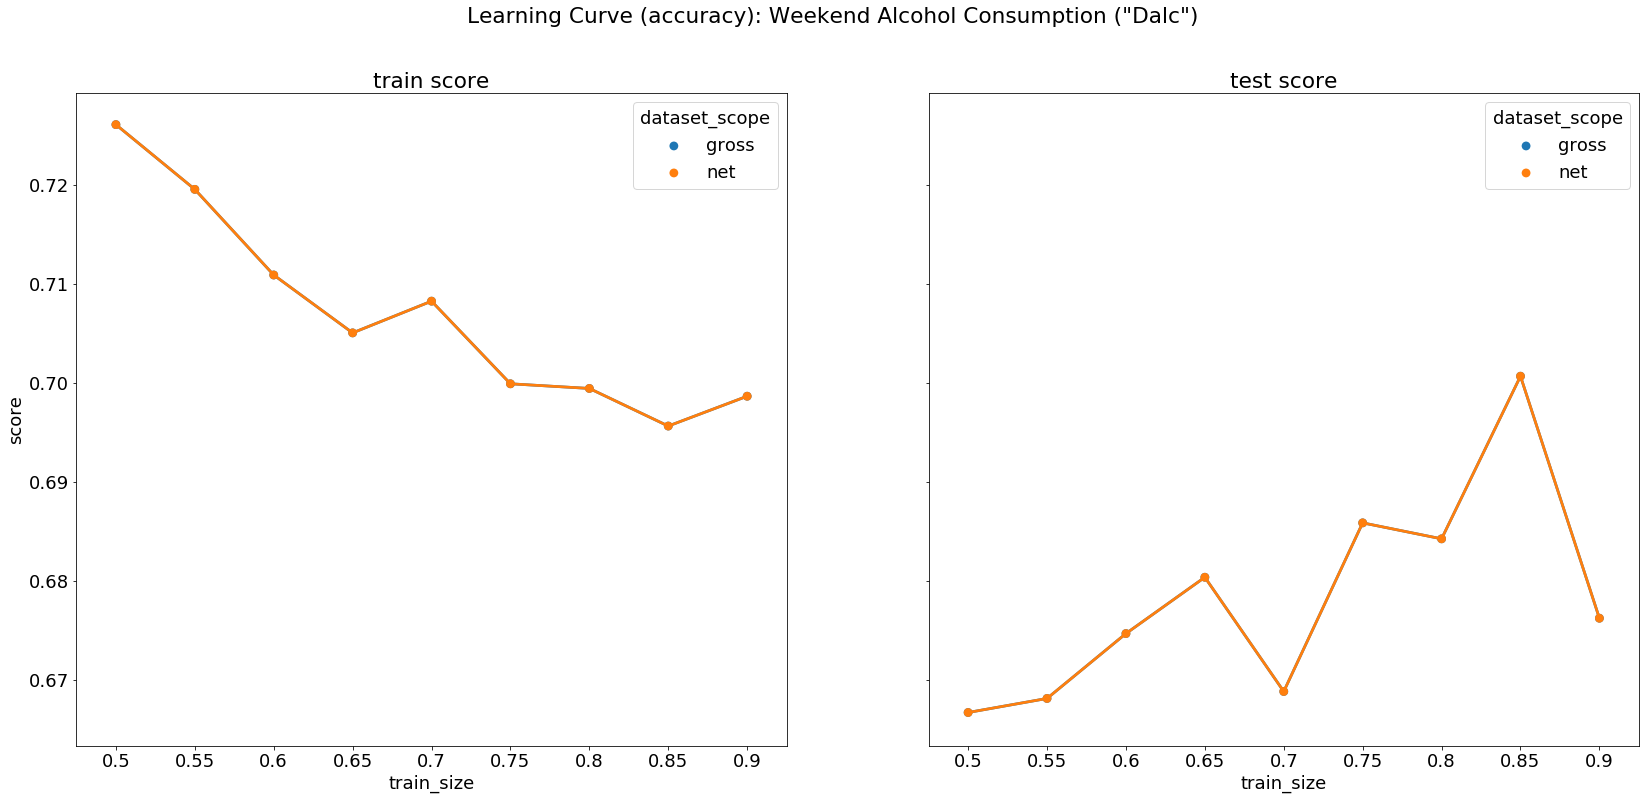

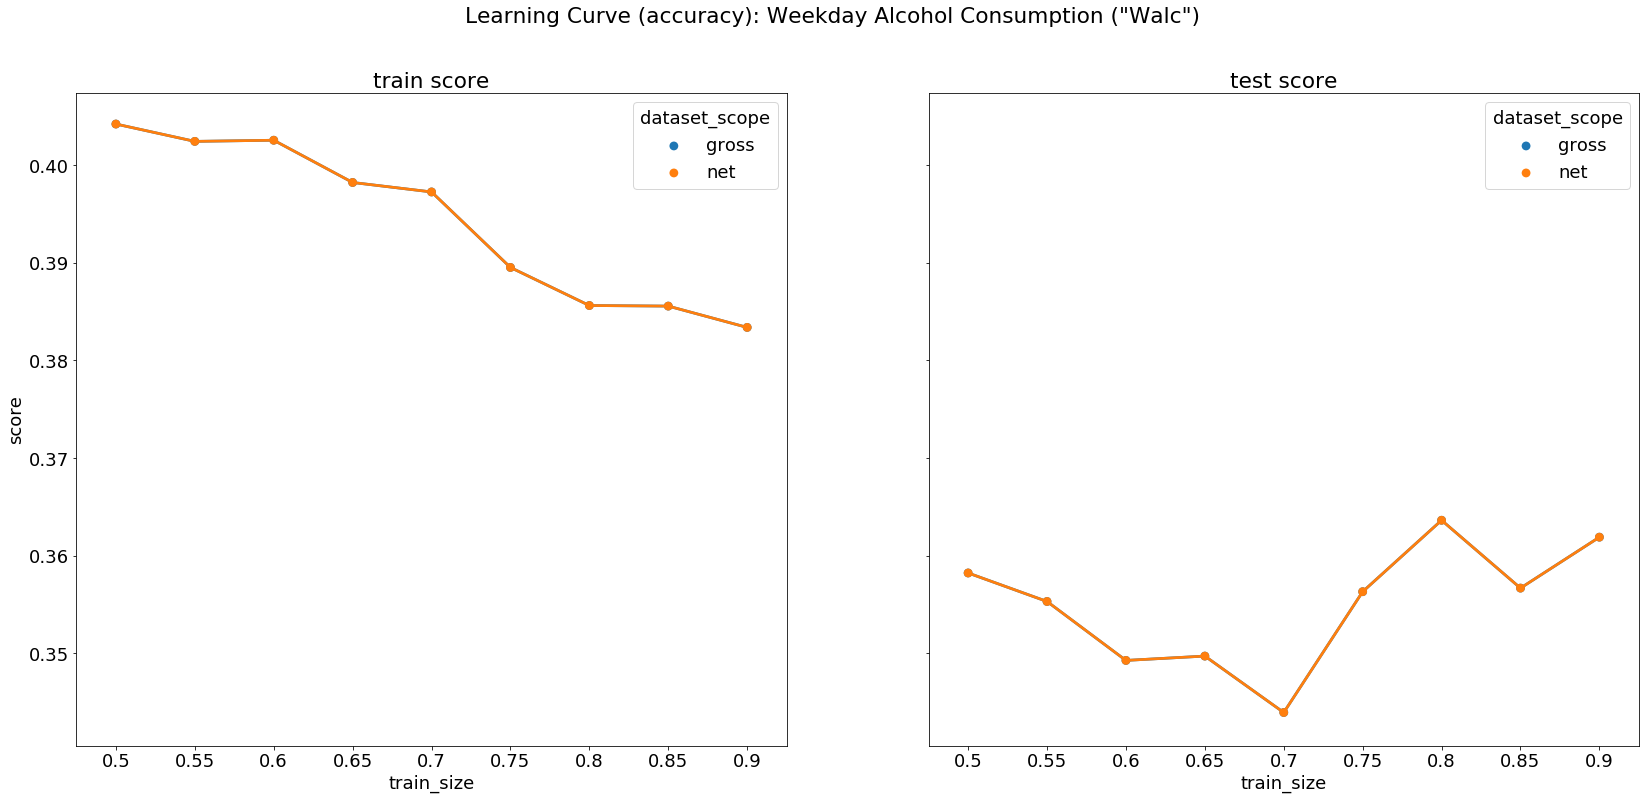

In [183]:
from sklearn.dummy import DummyClassifier

def check_dummy_learning_curve(train_size, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=train_size)

    nbclf = DummyClassifier(strategy="most_frequent", random_state=0).fit(X_train, y_train)
    
    #just accuracy to start off, but should change to roc_auc
    score_train = nbclf.score(X_train, y_train)
    score_test = nbclf.score(X_test, y_test)

    return(train_size, score_train, score_test)
    
    
plot_learning_curve(check_dummy_learning_curve, train_sizes, net_and_gross_data);

You may be wondering where the "gross" line is. It has been perfectly superimposed by the "net" line (because the stratified dummy classifier predicts the test class targets consistent with the frequency of the training values independent of the features in either set).

The dummy classifier has set a baseline against which the other models can be evaluated:
* Weekend Drinking (Dalc): 0.68
* Weekday Drinking (Walc): 0.36

### Naive Bayes


Mean test score across training set size
                      test_score
target dataset_scope            
Dalc   gross            0.129983
       net              0.654653
Walc   gross            0.211678
       net              0.344520


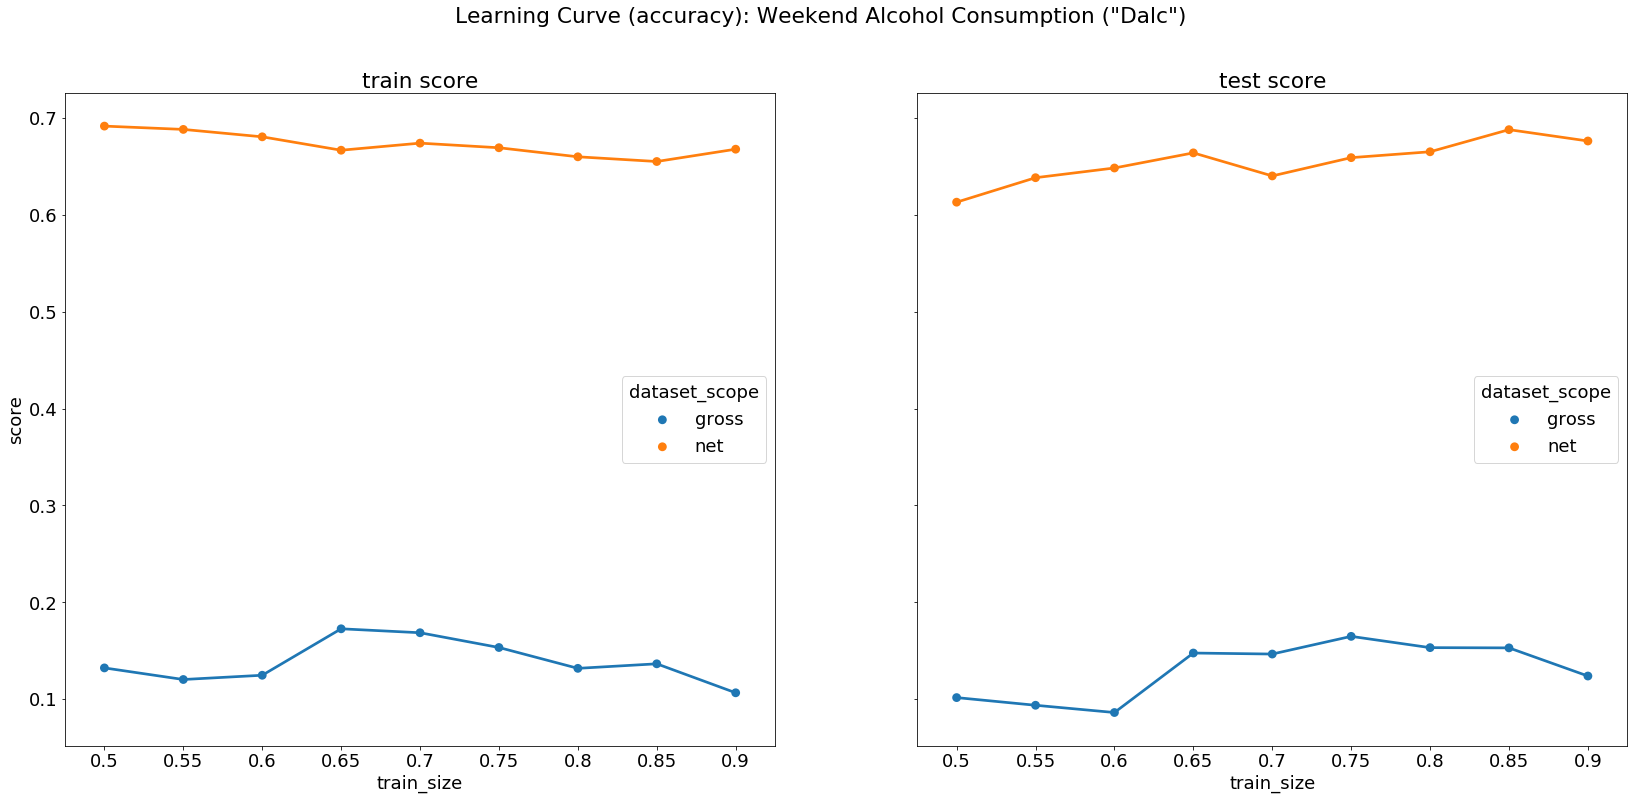

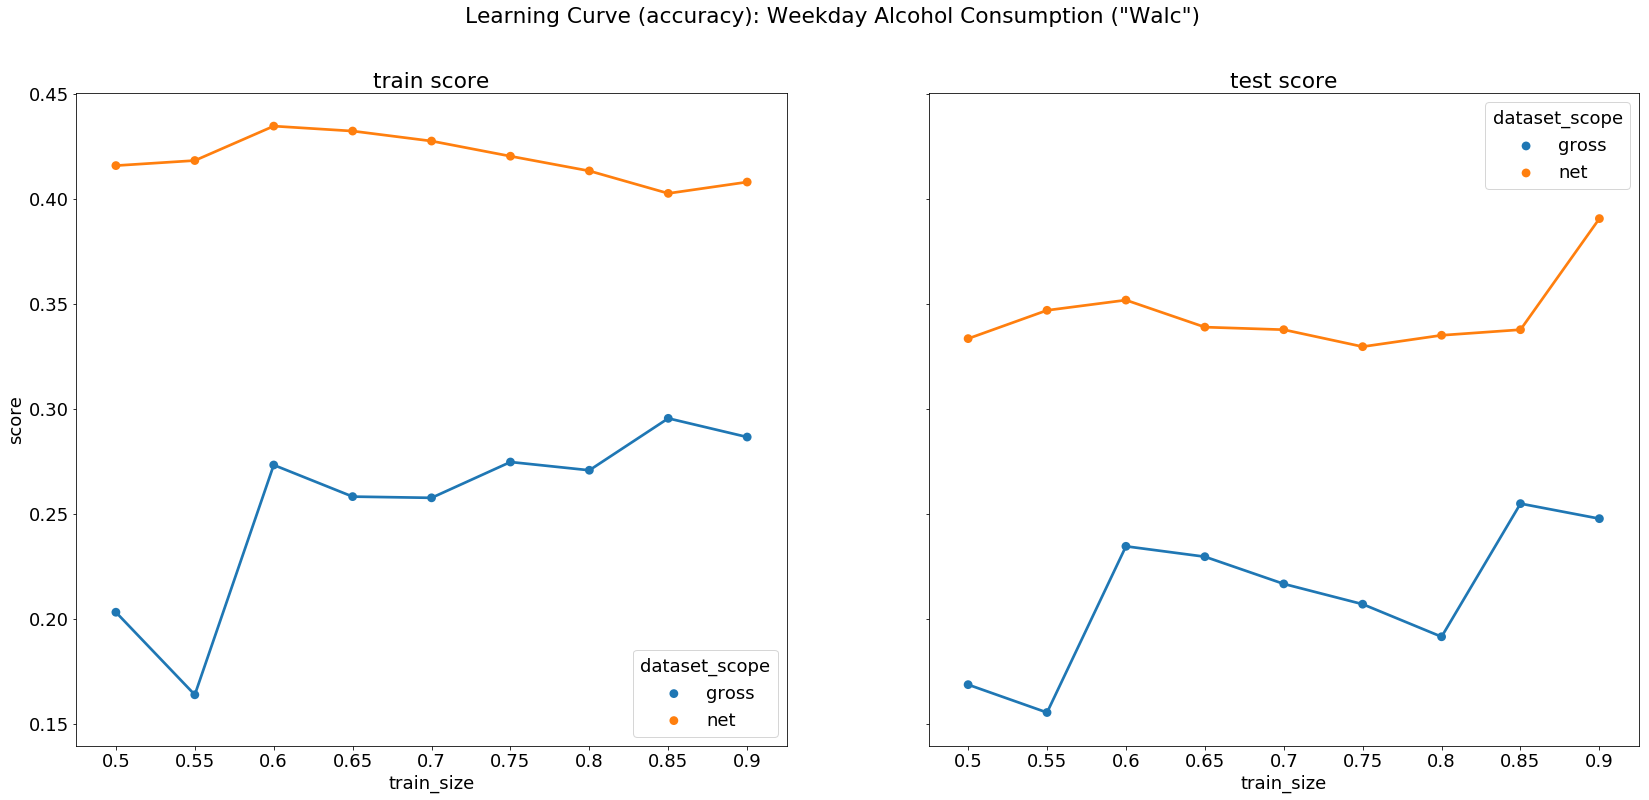

In [184]:
from sklearn.naive_bayes import GaussianNB

def check_nbclassifier_learning_curve(train_size, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=train_size)

    nbclf = GaussianNB().fit(X_train, y_train)
    
    #just accuracy to start off, but should change to roc_auc
    score_train = nbclf.score(X_train, y_train)
    score_test = nbclf.score(X_test, y_test)

    return(train_size, score_train, score_test)
    
    
plot_learning_curve(check_nbclassifier_learning_curve, train_sizes, net_and_gross_data);

Out of the box, 
* the low performance on the train and test scores suggest underfitting on this model.
* the performance is even lower than the dummy classifier, perhaps due to the violation of the independence assumption.

### Random Forest

Mean test score across training set size
                      test_score
target dataset_scope            
Dalc   gross            0.716332
       net              0.666150
Walc   gross            0.489340
       net              0.365949


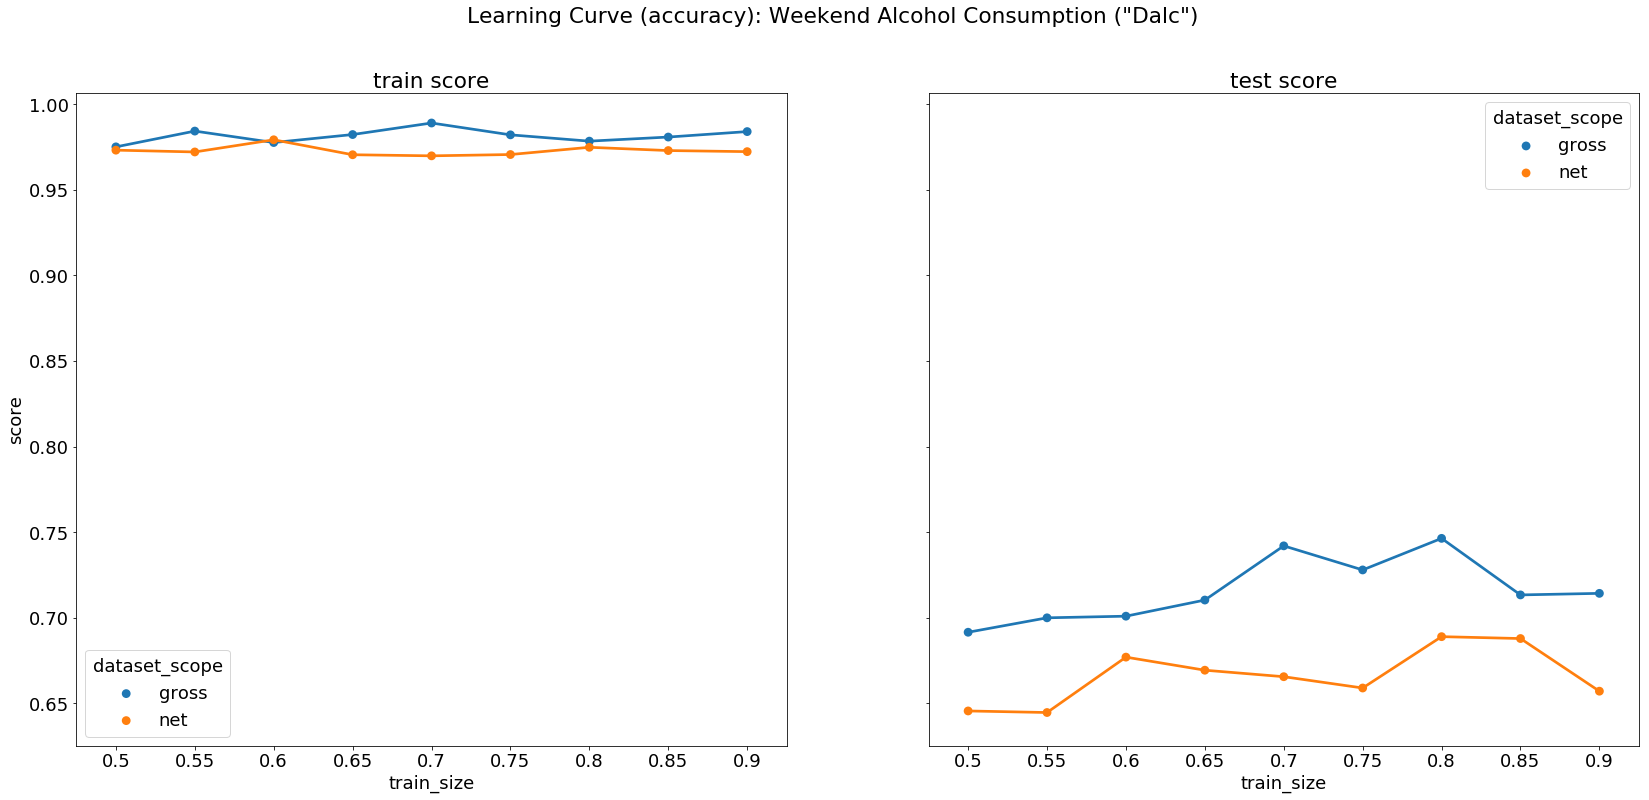

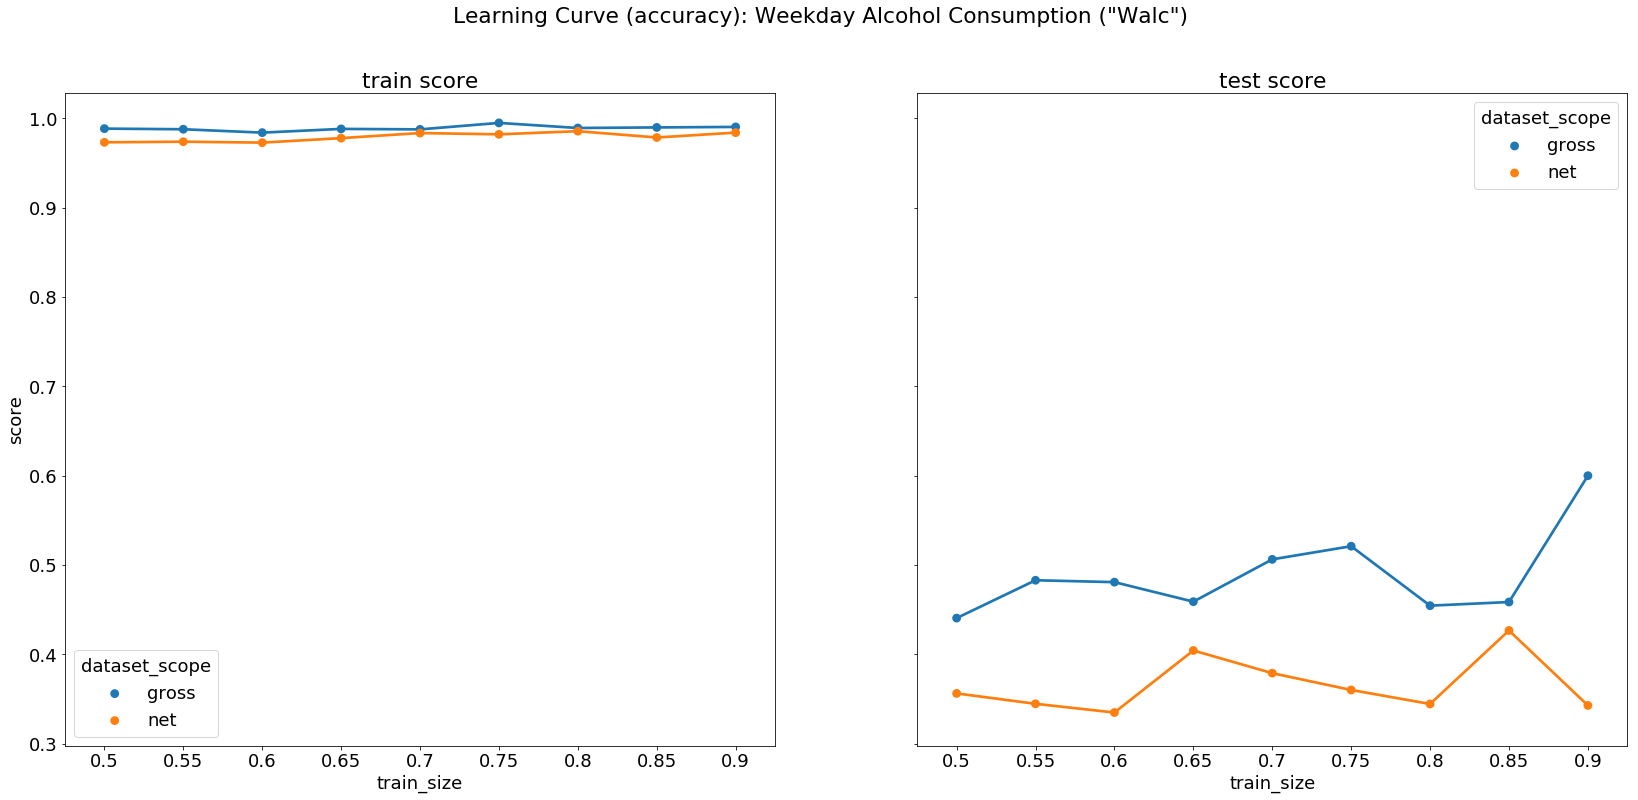

In [185]:
from sklearn.ensemble import RandomForestClassifier

#even there are a few lines of repeated code here, it felt more sensible to keep it in case I want to change params on the classifier
def check_randomforest_learning_curve(train_size, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=train_size)

    clf = RandomForestClassifier().fit(X_train, y_train)
    
    #just accuracy to start off, but should change to roc_auc
    score_train = clf.score(X_train, y_train)
    score_test = clf.score(X_test, y_test)

    return(train_size, score_train, score_test)
    
    
plot_learning_curve(check_randomforest_learning_curve, train_sizes, net_and_gross_data);

0.71 Walc, 0.49 on Dalc

The test score patterns suggest that more data will greatly increase the strength of this model.

However, with random forest models, interpretability suffers. So, while we may have a model that could strongly predict whether a student is at risk of heavy drinking, it is difficult for us to communicate why we believe a student is at risk

### Linear Discriminant Analysis

C:\Users\Joey\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Joey\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Mean test score across training set size
                      test_score
target dataset_scope            
Dalc   gross            0.679051
       net              0.677476
Walc   gross            0.397460
       net              0.340481


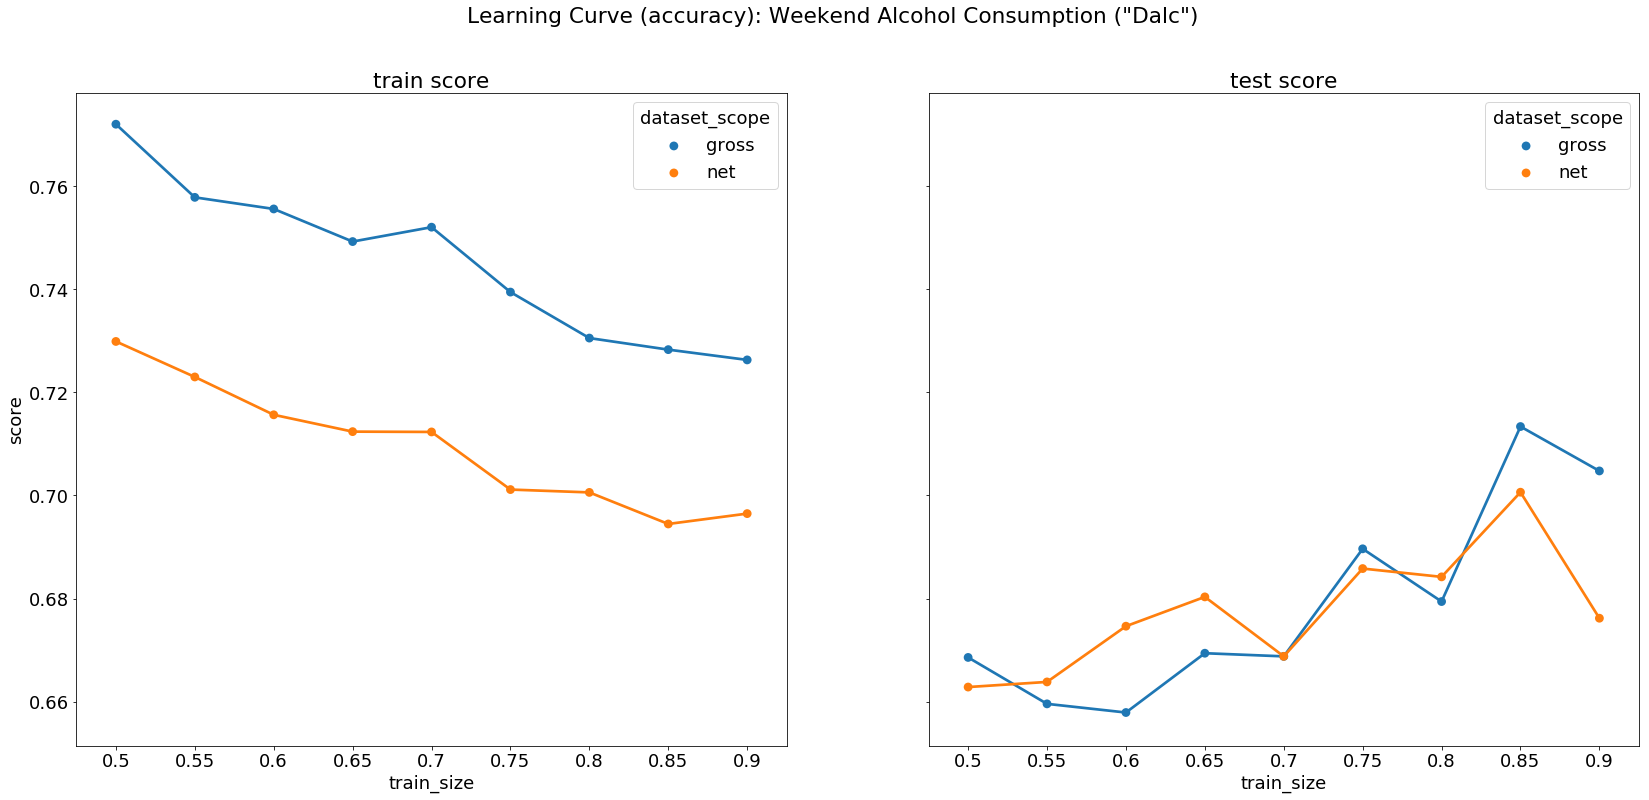

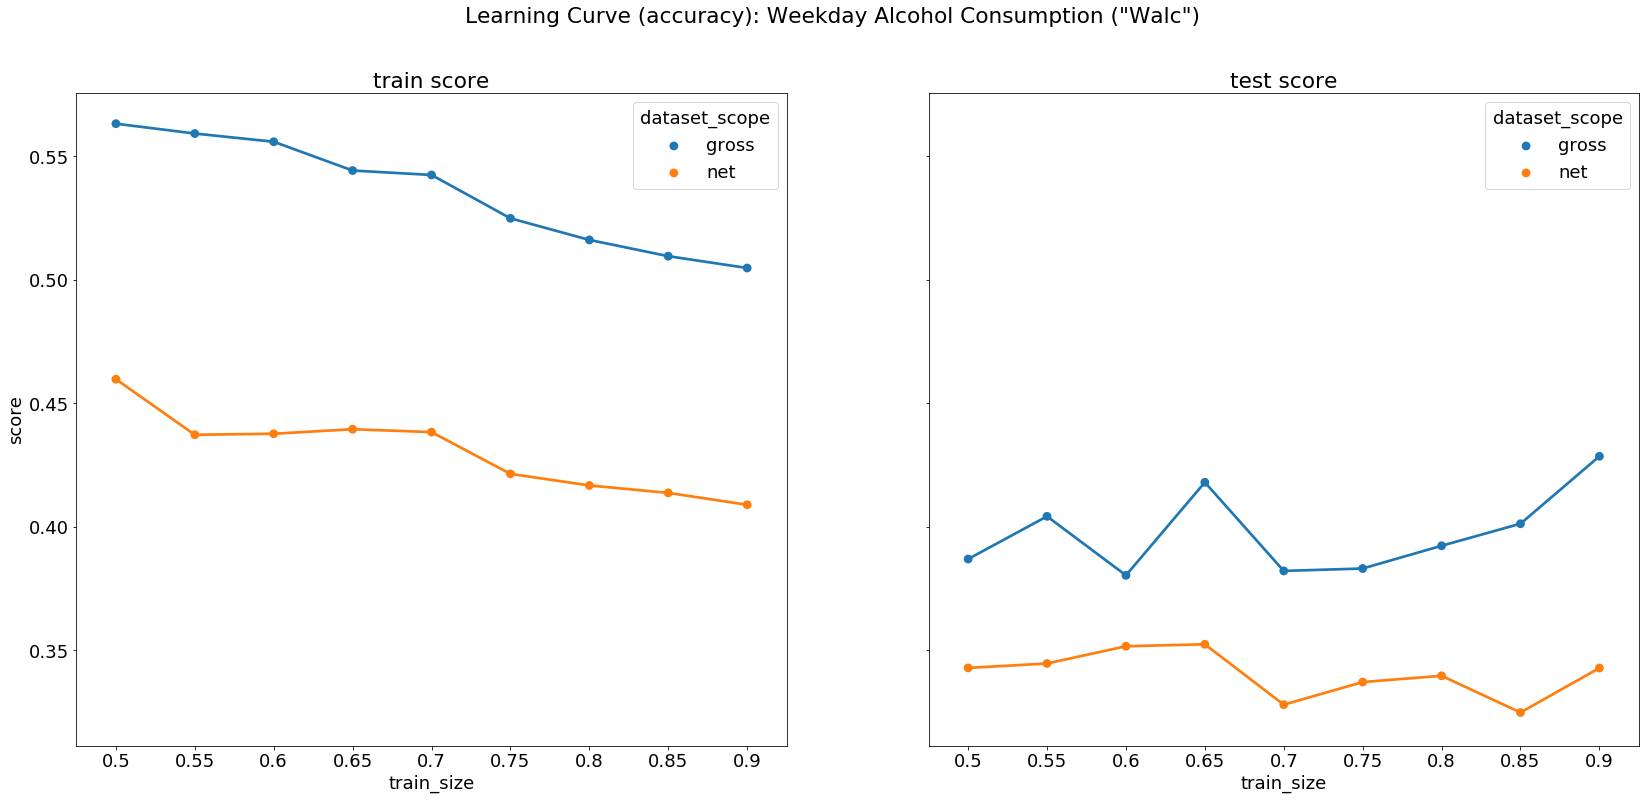

In [186]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#even there are a few lines of repeated code here, it felt more sensible to keep it in case I want to change params on the classifier
def check_lda_learning_curve(train_size, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=train_size)

    clf = LinearDiscriminantAnalysis().fit(X_train, y_train)
    
    #just accuracy to start off, but should change to roc_auc
    score_train = clf.score(X_train, y_train)
    score_test = clf.score(X_test, y_test)

    return(train_size, score_train, score_test)
    
    
plot_learning_curve(check_lda_learning_curve, train_sizes, net_and_gross_data);

Both on the gross sets
0.68
0.48

In [115]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

#even there are a few lines of repeated code here, it felt more sensible to keep it in case I want to change params on the classifier
def check_qda_learning_curve(train_size, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=train_size)

    clf = QuadraticDiscriminantAnalysis().fit(X_train, y_train)
    
    #just accuracy to start off, but should change to roc_auc
    score_train = clf.score(X_train, y_train)
    score_test = clf.score(X_test, y_test)

    return(train_size, score_train, score_test)
    
    
#plot_learning_curve(check_qda_learning_curve, train_sizes, net_and_gross_data);0

It seems the feature needs to be massaged a little to work with Quadratic. It might only need a little pca.

Could just throw up a plot to give the reasons why the model isn't compatible with the data:
* collinearity
* has only 1 sample in class 1

###  KNN

Mean test score across training set size
                      test_score
target dataset_scope            
Dalc   gross            0.741723
       net              0.712555
Walc   gross            0.565167
       net              0.505561


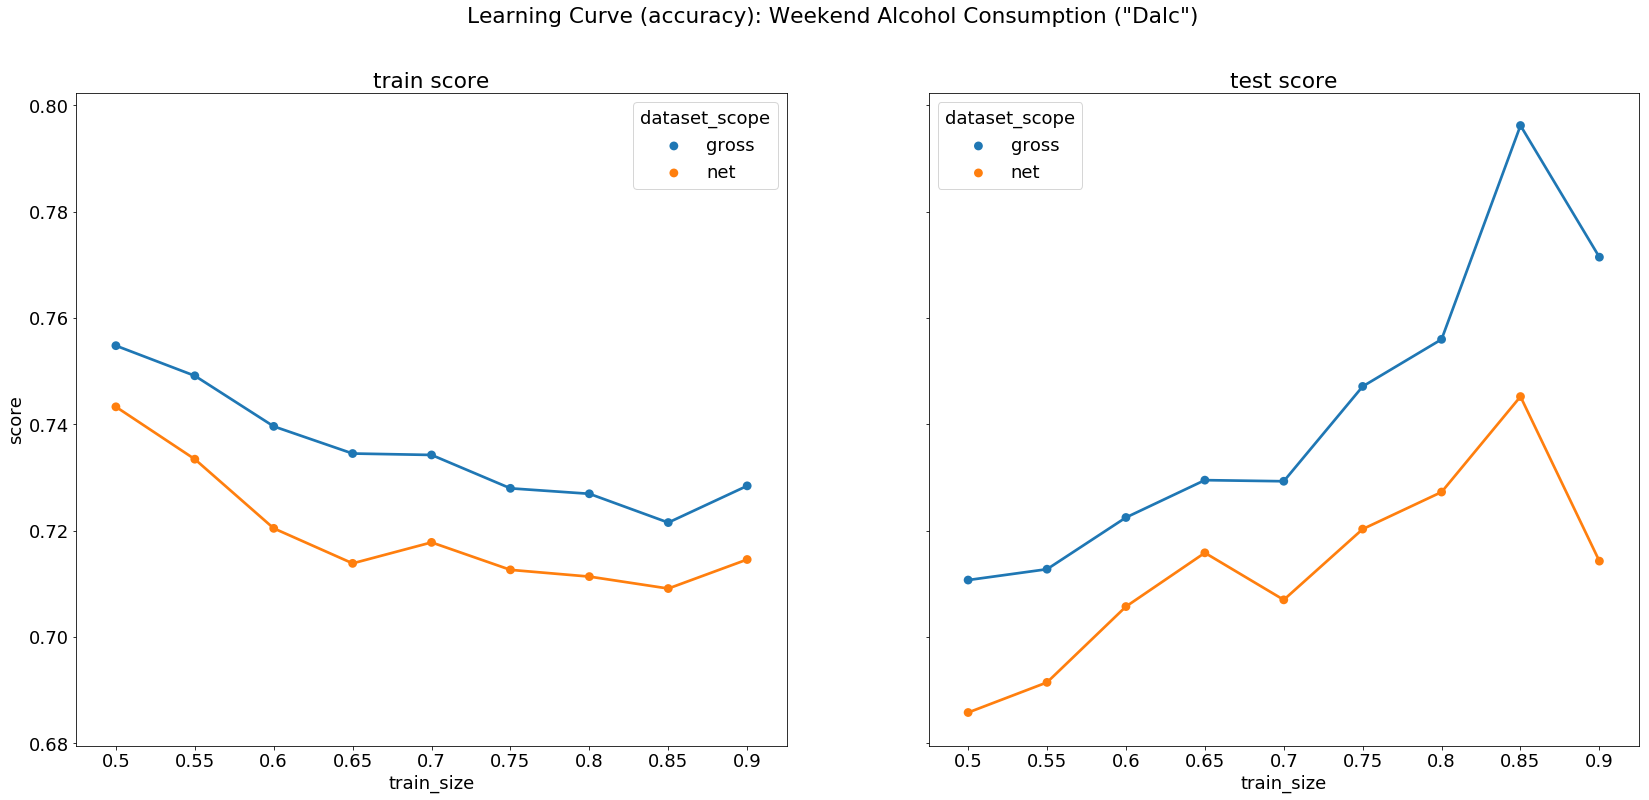

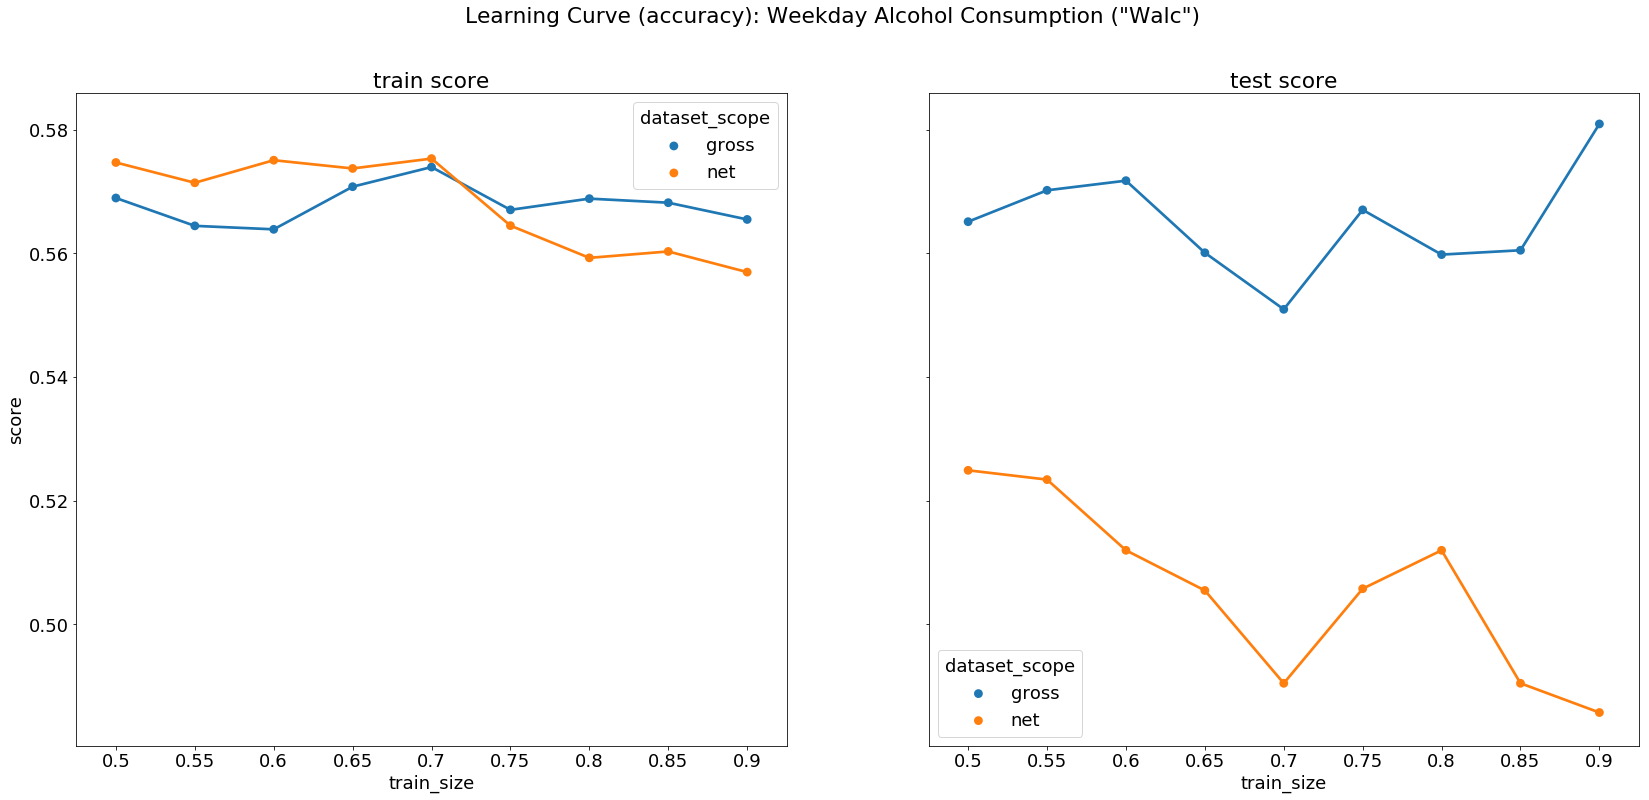

In [187]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import learning_curve

def check_knn_learning_curve(train_size, X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=train_size)
    knn = KNeighborsClassifier().fit(X, y)

    score_train = knn.score(X_train, y_train)
    score_test = knn.score(X_test, y_test)

    return(train_size, score_train, score_test)
    
    
plot_learning_curve(check_knn_learning_curve, train_sizes, net_and_gross_data);

0.74
0.57

Unfortunately, the only conclusion that can be made is that the models are unstable with increasing training data size. This points to the dataset as being too small for these models to be effective.
## Predicting binge_drinker, heavy_drinker


In [ ]:
from sklearn.linear_model import LogisticRegression

gross_binge_drinker = {
    "name" : "gross_binge_dinker",
    "X" : data.iloc[:, :-4], 
    "y" : data.iloc[:,-4:-3].values.reshape(-1,)
}
net_binge_drinker = {
    "name" : "net_binge_drinker",
    "X" : net_data.iloc[:, :-4],
    "y" : net_data.iloc[:,-4:-3].values.reshape(-1,)
}    
gross_heavy_drinker = {
    "name" : "gross_heavy_drinker",
    "X" : data.iloc[:, :-4], 
    "y" : data.iloc[:, -3:-2].values.reshape(-1,)
}
net_heavy_drinker = {
    "name" : "net_heavy_drinker",
    "X" : net_data.iloc[:, :-4],
    "y" : net_data.iloc[:, -3:-2].values.reshape(-1,)
} 

binge_and_heavy_drinking_patterns = [gross_binge_drinker, net_binge_drinker, gross_heavy_drinker, net_heavy_drinker]

### Get baseline: Stratified Dummy Classifier

Mean test score across training set size
                      test_score
target dataset_scope            
Dalc   gross            0.532041
       net              0.532041
Walc   gross            0.209050
       net              0.209050


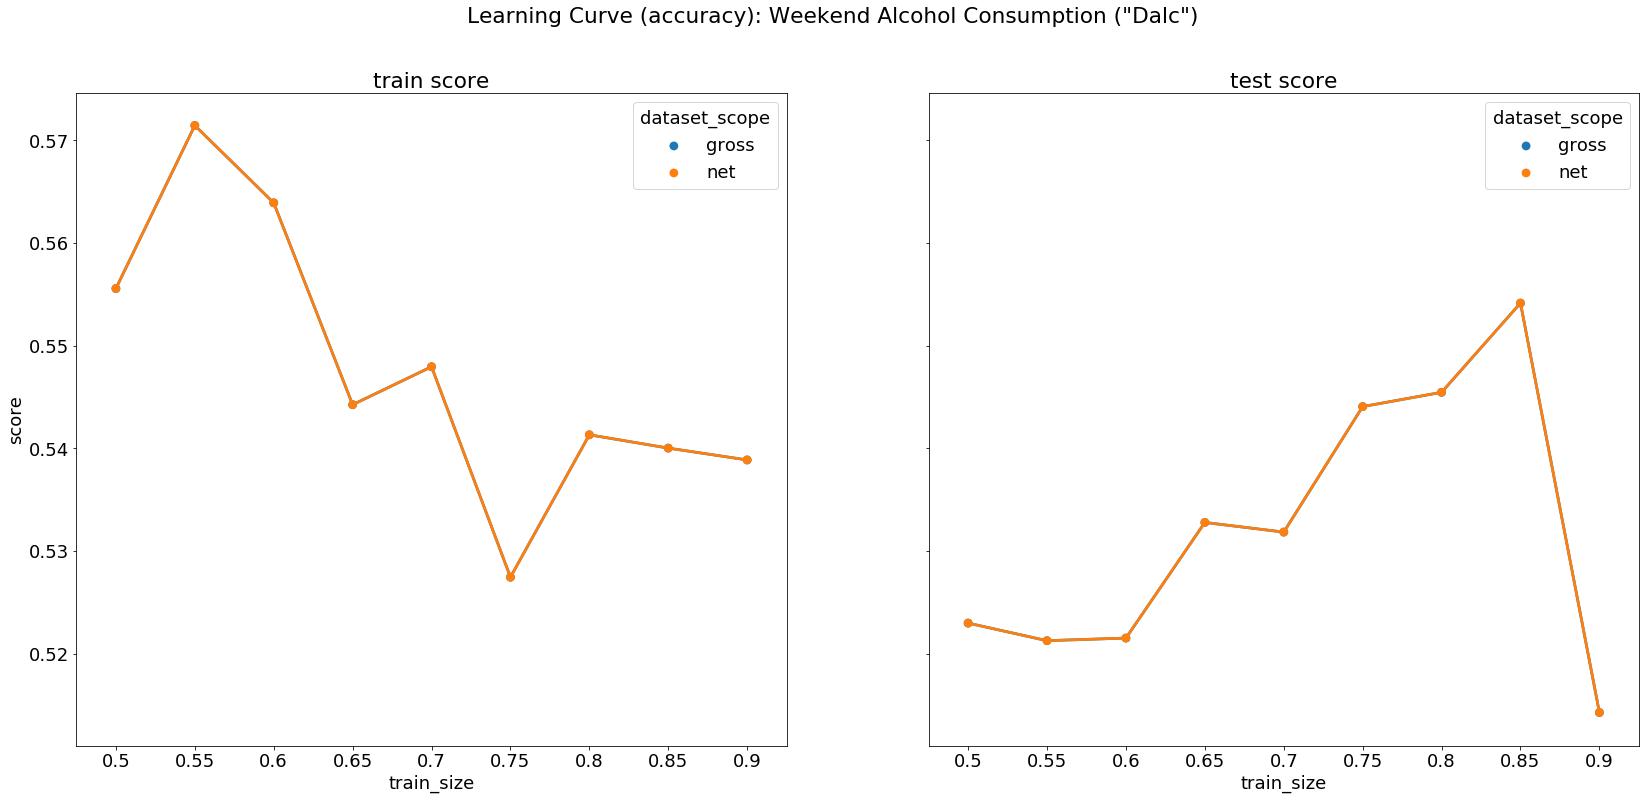

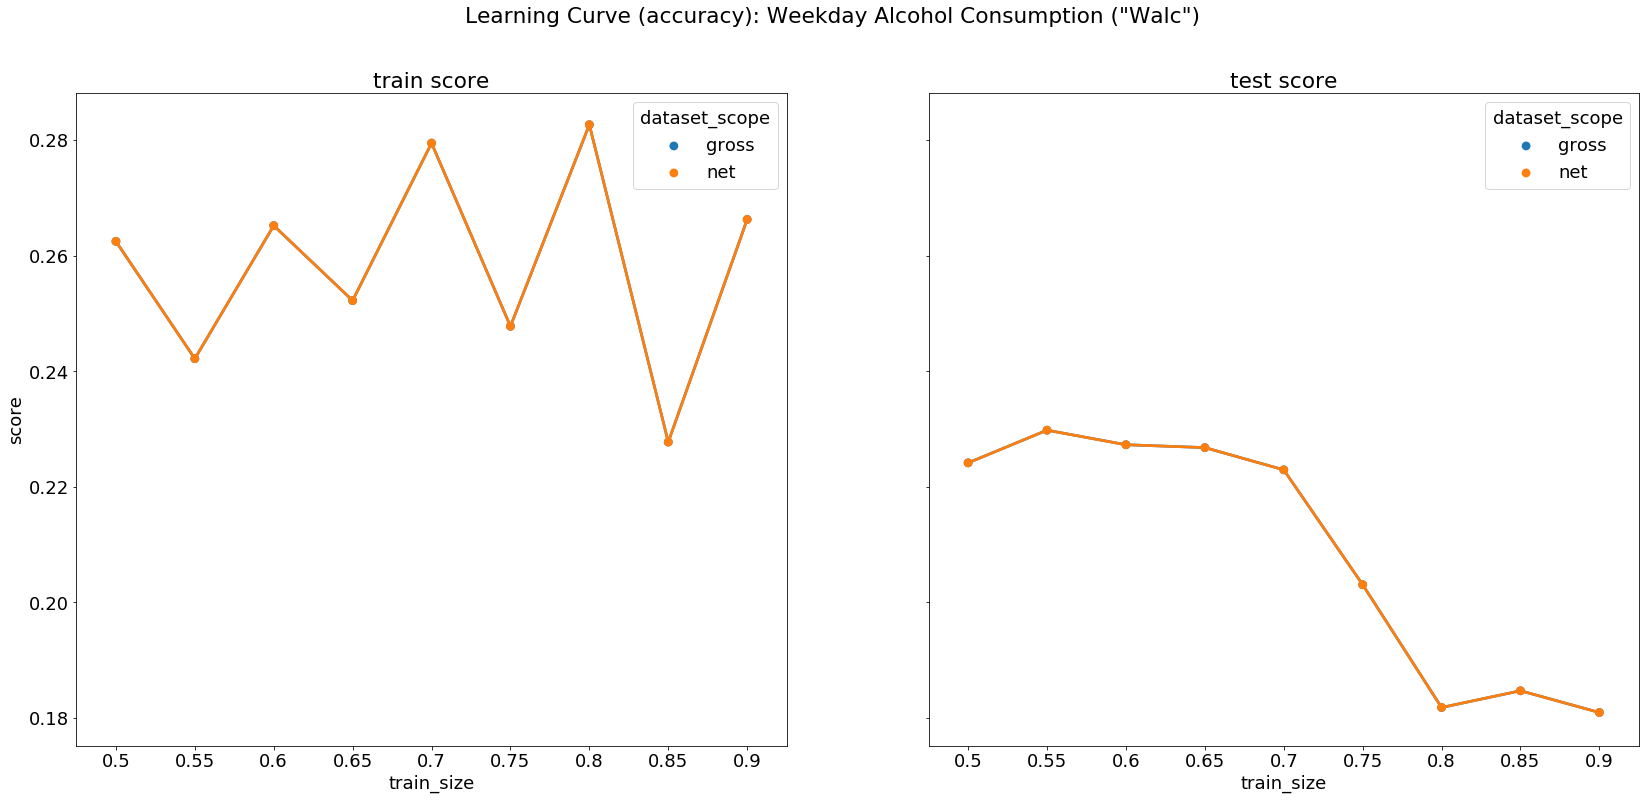

In [189]:
def check_dummy_drinking_pattern_learning_curve(train_size, X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=train_size)
    
    clf = DummyClassifier(random_state=0).fit(X, y)

    score_train = clf.score(X_train, y_train)
    score_test = clf.score(X_test, y_test)

    return(train_size, score_train, score_test)

plot_learning_curve(check_dummy_drinking_pattern_learning_curve, train_sizes, binge_and_heavy_drinking_patterns);
#the first graph shows performance for detecting heavy drinking
#the second graph shows performance for detecting binge drinking

Heavy drinking - 0.53
Binge drinking - 0.21

### Logistic Regression

Mean test score across training set size
                      test_score
target dataset_scope            
Dalc   gross            0.724013
       net              0.676090
Walc   gross            0.488303
       net              0.375934


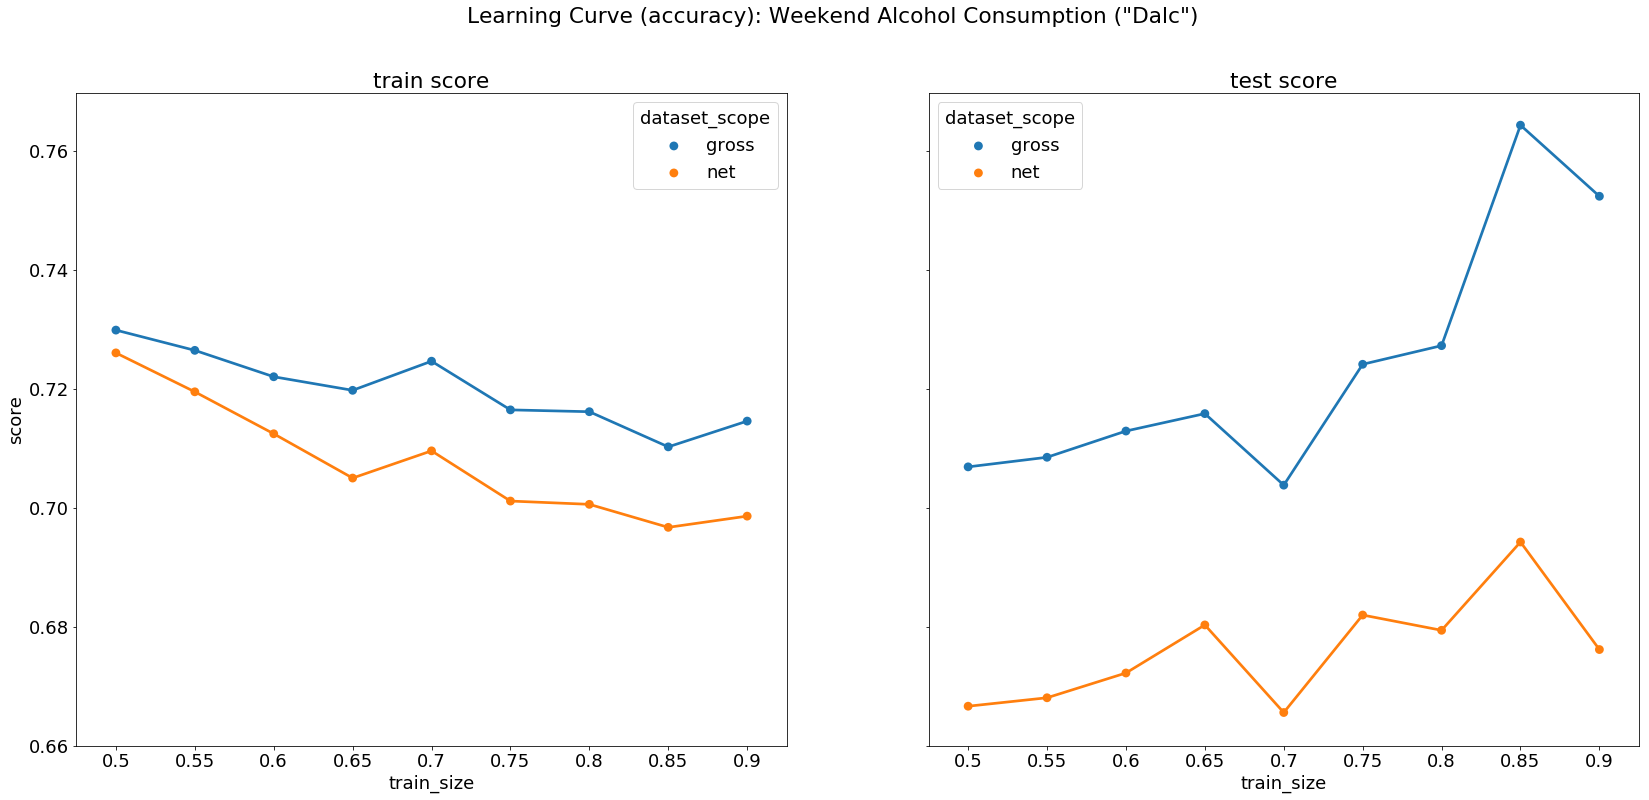

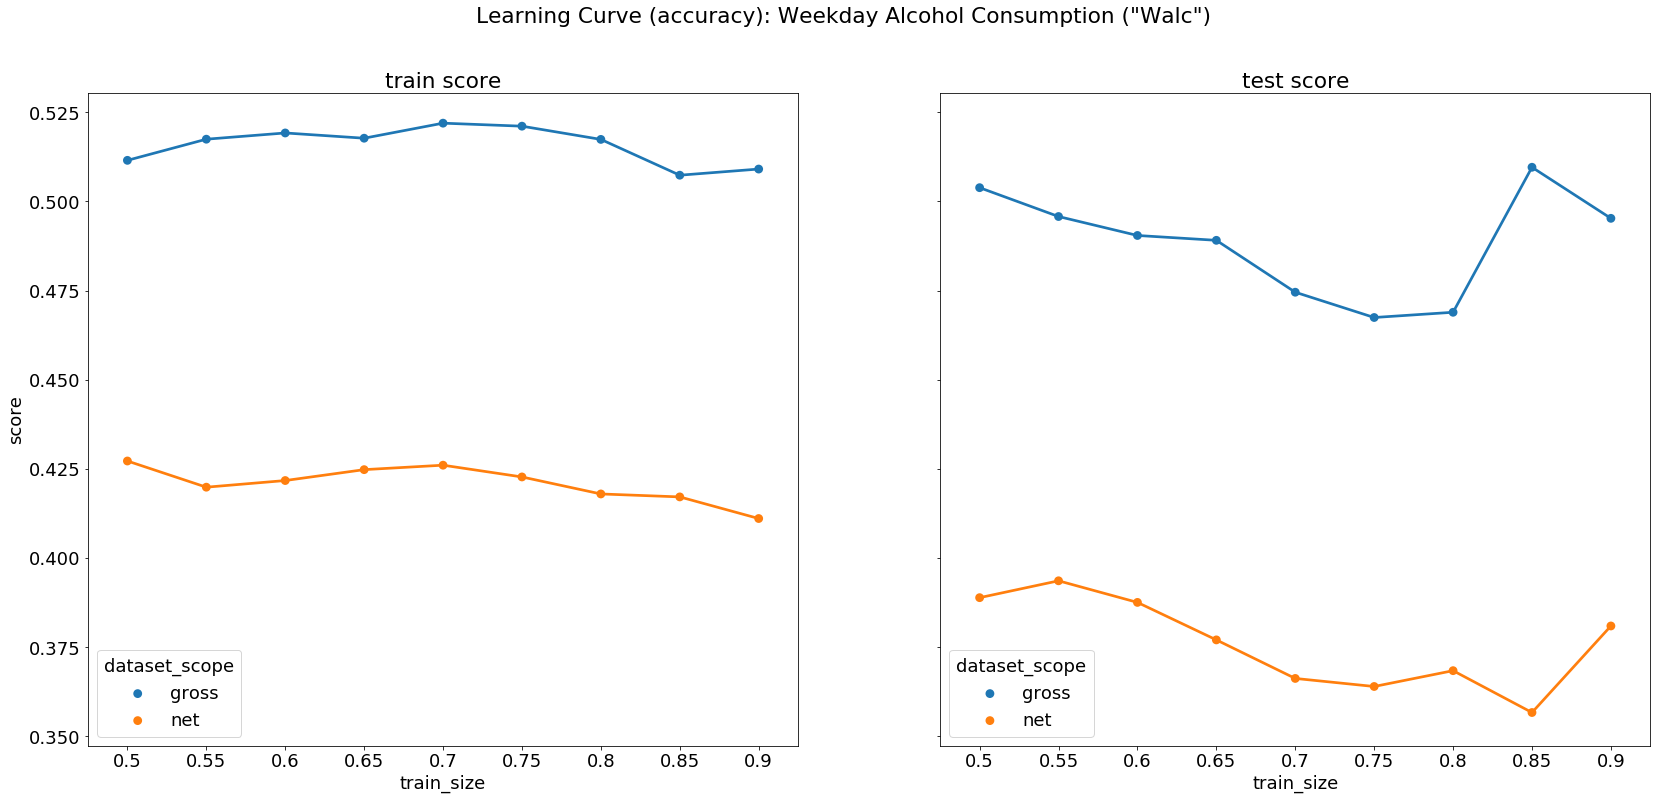

In [190]:
def check_logit_learning_curve(train_size, X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=train_size)
    
    clf = LogisticRegression().fit(X, y)

    score_train = clf.score(X_train, y_train)
    score_test = clf.score(X_test, y_test)

    return(train_size, score_train, score_test)
    
    
plot_learning_curve(check_logit_learning_curve, train_sizes, binge_and_heavy_drinking_patterns);


* Heavy 0.72
* Binge 0.49

C:\Users\Joey\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Mean test score across training set size
                      test_score
target dataset_scope            
Dalc   gross            0.732593
       net              0.679258
Walc   gross            0.472003
       net              0.381992


0

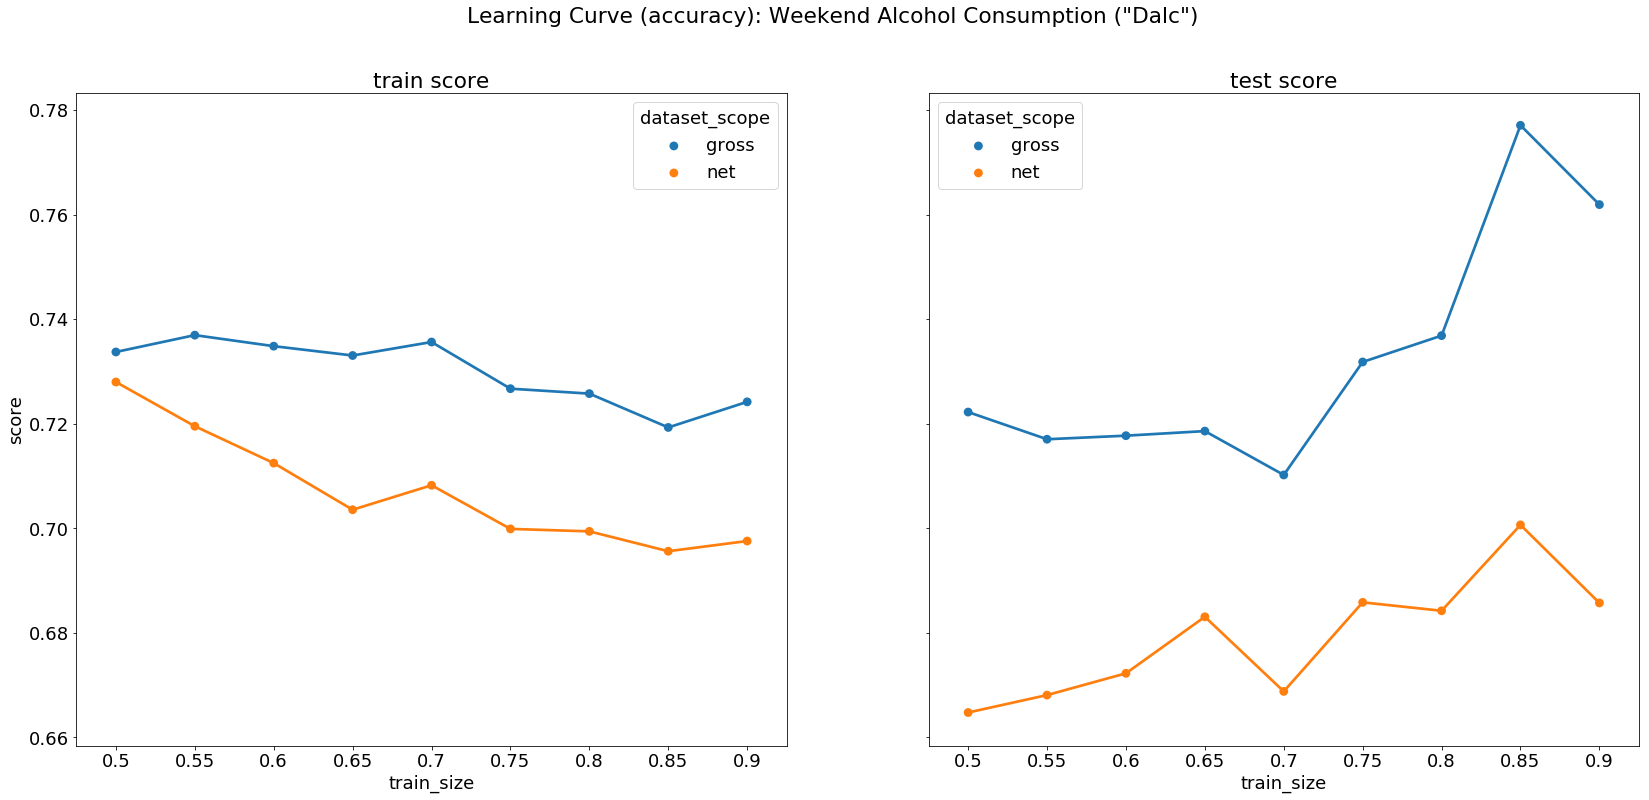

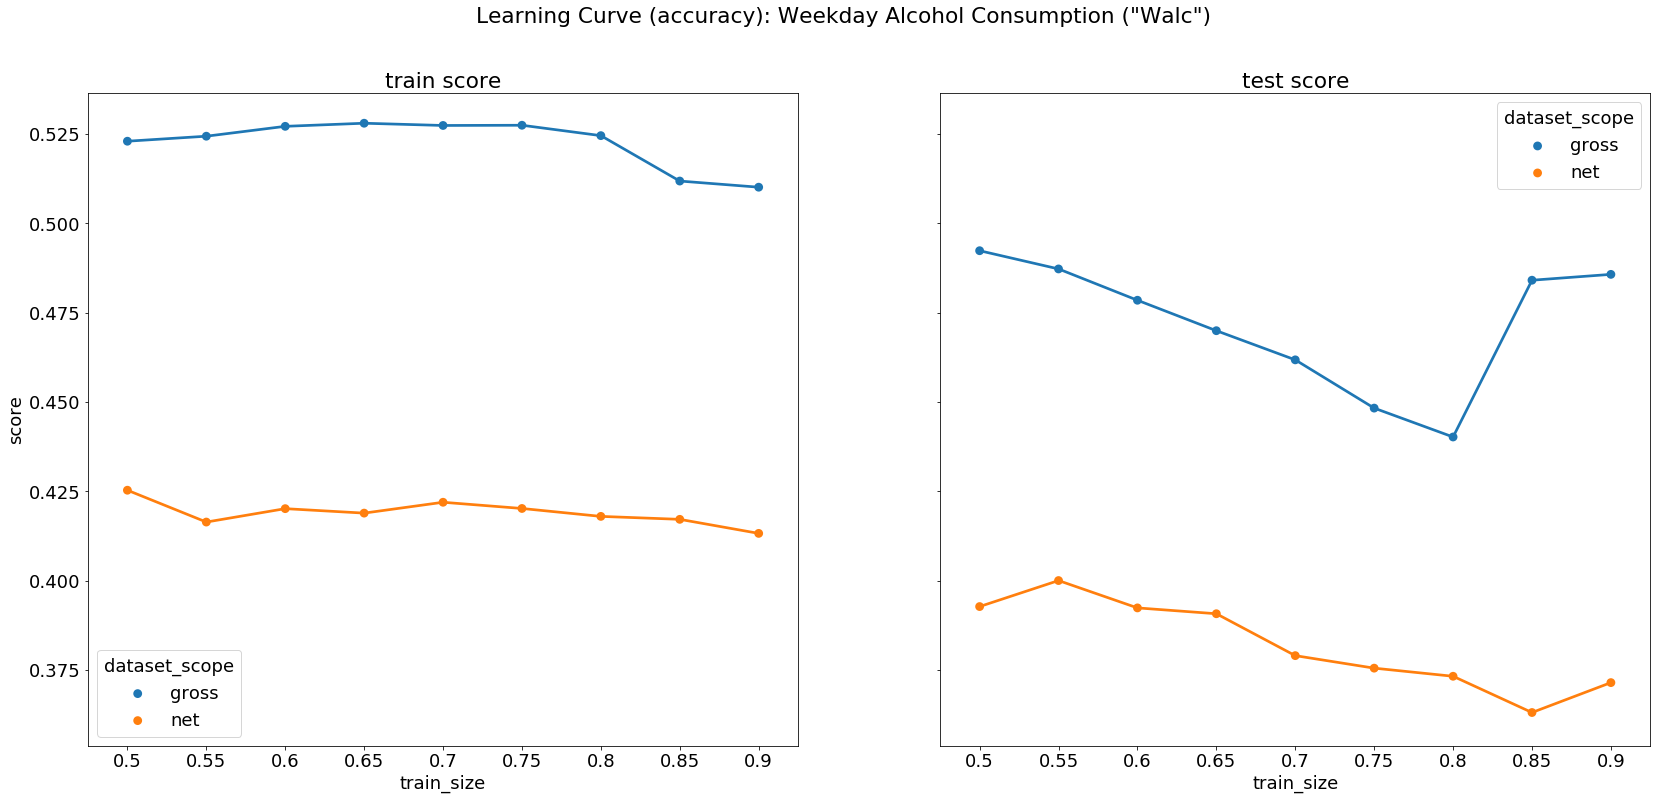

In [192]:
def check_lda_drinking_habits_learning_curve(train_size, X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=train_size)
    
    clf = LinearDiscriminantAnalysis().fit(X, y)

    score_train = clf.score(X_train, y_train)
    score_test = clf.score(X_test, y_test)

    return(train_size, score_train, score_test)
    
    
plot_learning_curve(check_lda_drinking_habits_learning_curve, train_sizes, binge_and_heavy_drinking_patterns);0

Heavy - 0.73
Binge - 0.48